## Session 4: Non-Parametric Regression 

In this session, we are going to have a look at semi-and non parametric forms of regressions. 

In general, Nonparametric regression is a category of regression analysis in which the predictor does not take a predetermined form but is constructed according to information derived from the data. 

That is, **no parametric form is assumed for the relationship between predictors and dependent variable**. 

Nonparametric regression requires larger sample sizes than regression based on parametric models because the data must supply the model structure as well as the model estimates.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm

from scipy.stats import norm
from statsmodels.nonparametric.kernel_regression import KernelReg
from pygam import LinearGAM, s, f, LogisticGAM
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
from patsy import dmatrix

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# Set global parameters
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

In [3]:
wage = "https://raw.githubusercontent.com/matteocourthoud/Machine-Learning-for-Economic-Analysis-2020/master/data/Wage.csv"

In [4]:
df = pd.read_csv(wage)

In [5]:
df.head()

,Unnamed: 0,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  3000 non-null   int64  
 1   year        3000 non-null   int64  
 2   age         3000 non-null   int64  
 3   sex         3000 non-null   object 
 4   maritl      3000 non-null   object 
 5   race        3000 non-null   object 
 6   education   3000 non-null   object 
 7   region      3000 non-null   object 
 8   jobclass    3000 non-null   object 
 9   health      3000 non-null   object 
 10  health_ins  3000 non-null   object 
 11  logwage     3000 non-null   float64
 12  wage        3000 non-null   float64
dtypes: float64(2), int64(3), object(8)
memory usage: 304.8+ KB


In [7]:
df.isna().sum()

Unnamed: 0    0
year          0
age           0
sex           0
maritl        0
race          0
education     0
region        0
jobclass      0
health        0
health_ins    0
logwage       0
wage          0
dtype: int64

As we can see, there are zero na values in the dataset, which is good. 

### Polynomial Regression and Step Functions

As we have seen in the first lecture, the most common way to introduce a non-linear relationship: 

$$
{y_i = \beta_0 + \beta_1x_i + \epsilon_i}
$$

with a polynomial:

$$
{y_i = \beta_0 + \beta_1x_i + \beta_2x_2^2 + \beta_3x^3 + ... + \epsilon_i}
$$

Now suppose we want to understand the relationship between wage and age. We plot it first:

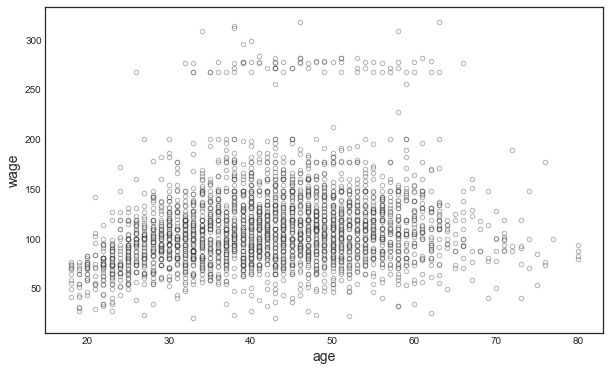

In [8]:
df.plot.scatter(x = "age", y = "wage", color = "w", edgecolors = "k", alpha = 0.3)

The relationship is not really linear. Let's expand our linear regression polynomials of different degrees: 1 to 5.

#### Polynomial Expansions

In [9]:
X1 = PolynomialFeatures(1).fit_transform(df.age.values.reshape(-1,1))
X2 = PolynomialFeatures(2).fit_transform(df.age.values.reshape(-1,1))
X3 = PolynomialFeatures(3).fit_transform(df.age.values.reshape(-1,1))
X4 = PolynomialFeatures(4).fit_transform(df.age.values.reshape(-1,1))
X5 = PolynomialFeatures(5).fit_transform(df.age.values.reshape(-1,1))

#### Dummy Encoder with map

Our dependent varaible is going to be a dummy for income above 250.000 USD

In [10]:
y = (df.wage > 250).map({True: 1, False: 0}).values

If we run a regression now on a 4-degree polynomial expansion of age, this is what is looks like:

In [11]:
fit2 = sm.GLS(df.wage, X4).fit()
fit2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-184.1542,60.040,-3.067,0.002,-301.879,-66.430
x1,21.2455,5.887,3.609,0.000,9.703,32.788
x2,-0.5639,0.206,-2.736,0.006,-0.968,-0.160
x3,0.0068,0.003,2.221,0.026,0.001,0.013
x4,-3.204e-05,1.64e-05,-1.952,0.051,-6.42e-05,1.45e-07


In [12]:
fit2 = sm.GLS(df.wage, X4).fit()
fit2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-184.1542,60.040,-3.067,0.002,-301.879,-66.430
x1,21.2455,5.887,3.609,0.000,9.703,32.788
x2,-0.5639,0.206,-2.736,0.006,-0.968,-0.160
x3,0.0068,0.003,2.221,0.026,0.001,0.013
x4,-3.204e-05,1.64e-05,-1.952,0.051,-6.42e-05,1.45e-07


This is just to show that the GLS will deliver the same results as the OLS in our case. 

#### Comparison between polynomial model fit scores


We now compare different polynomial degrees. For each regression, we are going to look at a series of metrics:

- absolute residuals
- sum of squared residuals
- the difference in SSR w.r.t the 0-degree case
- F statistic

In [13]:
fit_1 =  sm.GLS(df.wage, X1).fit()
fit_2 =  sm.GLS(df.wage, X2).fit()
fit_3 =  sm.GLS(df.wage, X3).fit()
fit_4 =  sm.GLS(df.wage, X4).fit()
fit_5 =  sm.GLS(df.wage, X5).fit()

sm.stats.anova_lm(fit_1, fit_2, fit_3, fit_4, fit_5, typ=1)

/Users/nikolas.anic/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/nikolas.anic/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/nikolas.anic/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


The polynomial with degree 4 seems most appropriate

In [14]:
X = X4

#### Logistic regression to account for a binary dependent variable

Since we have a binary dependent variable, it would be best to account for it in our regression framework. One way to do so, is to run a logistic regression. 

First, let's look at the formula for logistic regressions: 

$$
{y_i = \sigma(\beta_0 + \beta_1x_i + \beta_2x_2^2 + \beta_3x^3 + ... + \epsilon_i)}
$$

Where $\sigma$ is a transformation function, which assigns a probability of being in an upper-class income segment based on the explaining variables.

In [15]:
clf = sm.GLM(y, X, family = sm.families.Binomial(sm.families.links.logit))
res = clf.fit()

/Users/nikolas.anic/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  """Entry point for launching an IPython kernel.


We first have to create a test data. Transform to polynomial degree 4 and run prediction. Our test dasta consists of each value for the age variable 18 to 80 (63 observations).

In [16]:
age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)
print("Age range:", df.age.min(), "to", df.age.max())

Age range: 18 to 80


Now, we can take the test array of the age vector and predict the values for the probability of being above a certain income threshold. 

A remark here is that we did not choose to create an independent test set from the training set. Here, we simply took the entire set to create a fitted model and then choose random points (one of each age) to be the test sample. 

In [17]:
X_test = PolynomialFeatures(4).fit_transform(age_grid)

In [18]:
pred = res.predict(X_test)

Now, let's plot the results:

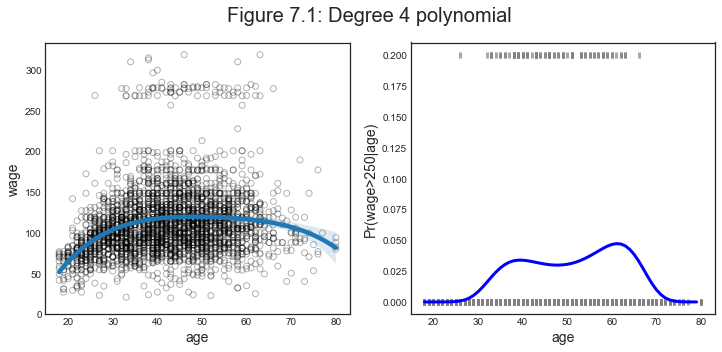

In [19]:
# Figure 7.1 
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,5))
fig.suptitle("Figure 7.1: Degree 4 polynomial")

ax1.scatter(df.age, df.wage, facecolor = "None", edgecolor = "k", alpha = 0.3)
sns.regplot(x = df.age, y = df.wage, order = 4, truncate = True, scatter = False, ax = ax1)
ax1.set_ylim(ymin=0)

# Logistic Regression showing P(wage > 250) fo the age range

ax2.plot(age_grid, pred, color = "b")

# Rug plot showing the distribution of wage>250 in the training data.

ax2.scatter(df.age, y/5, s=30, c = "grey", marker = "|", alpha = 0.7)

ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)');

### Stepwise functions

Using polynomial functions of the features as predictors in a linear model imposes a global structure on the non-linear function of age. We can instead use step functions in order to avoid imposing such a global structure. Here we **break the range of age into bins**, and fit a different constant in each bin.

In practice, this implies selecting K cutpoints $c_1, ..., c_k$in the range of age, and then construct K + 1 new variables: 

$$
C_0(age) = s(age<c_1)C_1(age) = s(c_1<age<c_2)C_2(age) = ... = s(c_{k-1}<age<c_k)C_k(age)
$$

Where s(.) is the indicator function.

First, we generate the cuts:

In [20]:
df_cut, bins = pd.cut(df.age, 4, retbins = True, right = True)
df_cut.value_counts(sort = False)

(17.938, 33.5]     750
(33.5, 49.0]      1399
(49.0, 64.5]       779
(64.5, 80.0]        72
Name: age, dtype: int64

#### Dataframe generation with cuts

Let's generate our dataframe:

In [21]:
df_steps = pd.concat([df.age, df_cut, df.wage], keys = ["age", "age_cuts", "wage"], axis = 1)
df_steps.head()

,age,age_cuts,wage
0,18,"(17.938, 33.5]",75.043154
1,24,"(17.938, 33.5]",70.476020
2,45,"(33.5, 49.0]",130.982177
3,43,"(33.5, 49.0]",154.685293
4,50,"(49.0, 64.5]",75.043154


#### Dummy Generation

Now, we can generate different dummies out of each bin

In [22]:
# Create dummy variable

df_steps_dummies = pd.get_dummies(df_steps.age_cuts)
df_steps_dummies.head()

,"(17.938, 33.5]","(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
0,1,0,0,0
1,1,0,0,0
2,0,1,0,0
3,0,1,0,0
4,0,0,1,0


#### Regression with stepwise functions for training data

We are now ready to run the regression:

In [23]:
reg3 = sm.GLM(df_steps.wage, df_steps_dummies).fit()
reg3.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
"(17.938, 33.5]",94.1584,1.476,63.790,0.000,91.265,97.051
"(33.5, 49.0]",118.2119,1.081,109.379,0.000,116.094,120.330
"(49.0, 64.5]",117.8230,1.448,81.351,0.000,114.984,120.662
"(64.5, 80.0]",101.7990,4.764,21.368,0.000,92.462,111.136


#### Linear Prediction of the test data

Now, we want to predict the values on the test data set:

In [24]:
# Put the test data in the same bins as the training data. Here, bins is saved as 4
bin_mapping = np.digitize(age_grid.ravel(), bins)
bin_mapping

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [25]:
X_test2 = pd.get_dummies(bin_mapping)

In [26]:
pred2 = reg3.predict(X_test2)

#### Logistic Regression of the test data

Also, we can use a logistic regression

In [27]:
clf2 = sm.GLM(y, df_steps_dummies,
              family=sm.families.Binomial(sm.families.links.logit))
res2 = clf2.fit()
pred3 = res2.predict(X_test2)

/Users/nikolas.anic/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  


#### Plotting of the stepwiswe function and logistics function stepwise

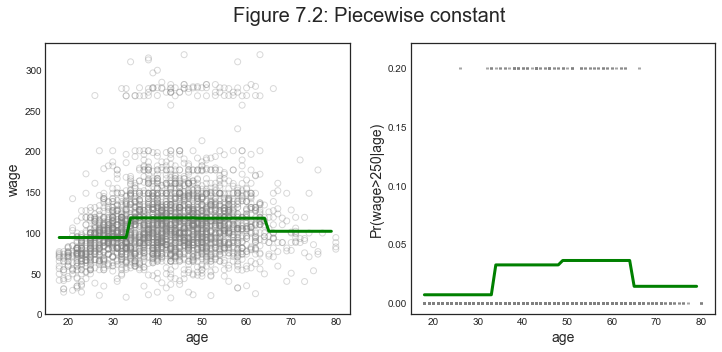

In [28]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,5))
fig.suptitle("Figure 7.2: Piecewise constant")

# Plotting the first training data on the predicted test data

ax1.scatter(df_steps.age, df_steps.wage, facecolor = "None", edgecolor = "grey", alpha = 0.3)
ax1.plot(age_grid, pred2, c = 'g')

ax1.set_xlabel('age')
ax1.set_ylabel('wage')
ax1.set_ylim(ymin=0)

# Logistic regression showing Pr(wage>250) for the age range

ax2.plot(age_grid, pred3, color='g')

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s=3, c='grey', marker='|', alpha=0.7)

ax2.set_ylim(-0.01,0.222)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)');


### Regression Splines


Idea: Combine polynomial regression with step functions: 

For example, immagine you want both a 3rd degreee and splitting in bins of two: 

$$ 
\begin{array}{ll}
      \beta_{01} + \beta_{11}x_i + \beta_{21}x_i^2 + \beta_{31}x_i^3 + \epsilon_i & x_i < c \\
      \beta_{02} + \beta_{12}x_i + \beta_{22}x_i^2 + \beta_{32}x_i^3 + \epsilon_i & else
\end{array}
$$

We are now going to plot four different examples for the ``age``and ``wage``example:

1. Discontinuous piecewise cubic
2. Continuous piecewise cubic
3. Quadratic (countinuous)
4. Continuous piecewise linear


In [29]:
df_short = df.iloc[:80,:]
age_grid_short = np.arange(df_short.age.min(), df_short.age.max()+1).reshape(-1,1)

In [53]:
# Discontinous piecewise cubic: 

df_short_1 = df_short[df_short["age"] < 50]
df_poly_3 = PolynomialFeatures(3).fit_transform(df_short_1.age.values.reshape(-1,1))
fit_poly_3 = sm.GLS(df_short_1.wage, df_poly_3).fit()

age_grid_short_poly_3 = np.arange(df_short_1.age.min(), df_short_1.age.max()+2).reshape(-1,1)
pred_poly_3 = fit_poly_3.predict(PolynomialFeatures(3).fit_transform(age_grid_short_poly_3))

##########################

df_short_2 = df_short[df_short["age"] >= 50]
df_poly_3_2 = PolynomialFeatures(3).fit_transform(df_short_2.age.values.reshape(-1,1))
fit_poly_3_2 = sm.GLS(df_short_2.wage, df_poly_3_2).fit()

age_grid_short_poly_3_2 = np.arange(df_short_2.age.min(), df_short_2.age.max()+2).reshape(-1,1)
pred_poly_3_2 = fit_poly_3_2.predict(PolynomialFeatures(3).fit_transform(age_grid_short_poly_3_2))


In [56]:
# Continuous piecewise cubic 

spline2 = "bs(x, knots=(50,50,50), degree=3, include_intercept=False)"
transformed_x2 = dmatrix(spline2, {"x": df_short.age}, return_type = "dataframe")
fit2 = sm.GLM(df_short.wage, transformed_x2).fit()
pred2 = fit2.predict(dmatrix(spline2, {"x": age_grid_short}, return_type = "dataframe"))


,Intercept,"bs(x, knots=(50, 50, 50), degree=3, include_intercept=False)[0]","bs(x, knots=(50, 50, 50), degree=3, include_intercept=False)[1]","bs(x, knots=(50, 50, 50), degree=3, include_intercept=False)[2]","bs(x, knots=(50, 50, 50), degree=3, include_intercept=False)[3]","bs(x, knots=(50, 50, 50), degree=3, include_intercept=False)[4]","bs(x, knots=(50, 50, 50), degree=3, include_intercept=False)[5]"
0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.0,0.371338,0.085693,0.006592,0.000000,0.000000,0.000000
2,1.0,0.061798,0.333710,0.600677,0.000000,0.000000,0.000000
3,1.0,0.112152,0.400543,0.476837,0.000000,0.000000,0.000000
4,1.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
75,1.0,0.085693,0.371338,0.536377,0.000000,0.000000,0.000000
76,1.0,0.000000,0.000000,0.216000,0.432000,0.288000,0.064000
77,1.0,0.333710,0.061798,0.003815,0.000000,0.000000,0.000000
78,1.0,0.000000,0.000000,0.110592,0.359424,0.389376,0.140608


In [51]:
# Quadratic (continuous)

spline3 = "bs(x, knots=(%s,%s), degree=2, include_intercept=False)" %  (min(df_short.age), max(df_short.age))
transformed_x3 = dmatrix(spline3, {"x": df_short.age}, return_type='dataframe')
fit3 = sm.GLM(df_short.wage, transformed_x3).fit()
pred3 = fit3.predict(dmatrix(spline3, {"x": age_grid_short}, return_type='dataframe'))


In [45]:
# Continuous piecewise linear

spline4 = "bs(x, knots=(%s,50), degree=1, include_intercept=False)" % min(df_short.age)
transformed_x4 = dmatrix(spline4, {"x": df_short.age}, return_type='dataframe')
fit4 = sm.GLM(df_short.wage, transformed_x4).fit()
pred4 = fit4.predict(dmatrix(spline4, {"x": age_grid_short}, return_type='dataframe'))

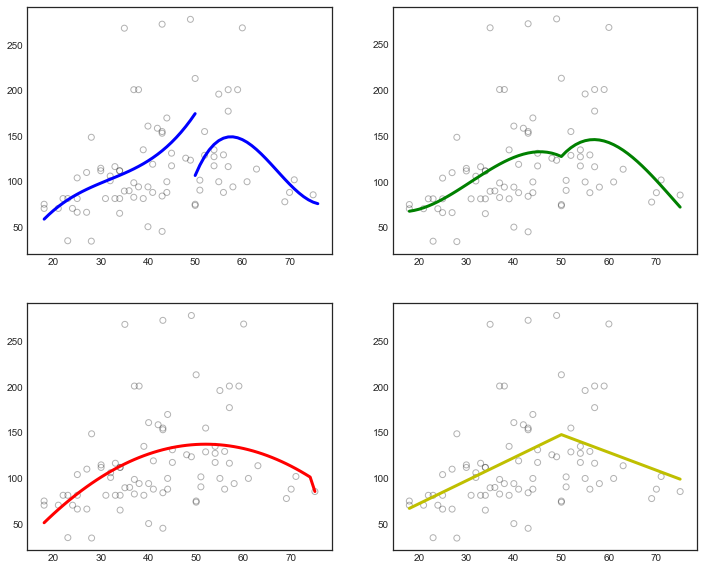

In [54]:
fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2,2, figsize=(12,10))

#Discontinuous piecewies cubic: 
ax1.plot(age_grid_short_poly_3, pred_poly_3, color = "b")
ax1.plot(age_grid_short_poly_3_2, pred_poly_3_2, color = "b")
ax1.scatter(df_short.age, df_short.wage, facecolor = "None", edgecolor = "k", alpha = 0.3)

ax2.plot(age_grid_short, pred2, color = "g")
ax2.scatter(df_short.age, df_short.wage, facecolor = "None", edgecolor = "k", alpha = 0.3)

ax3.plot(age_grid_short, pred3, color = "r")
ax3.scatter(df_short.age, df_short.wage, facecolor = "None", edgecolor = "k", alpha = 0.3)

ax4.plot(age_grid_short, pred4, color = "y")
ax4.scatter(df_short.age, df_short.wage, facecolor = "None", edgecolor = "k", alpha = 0.3)







The first example makes us think on why would we want out function to be discontinuous. Unless we expect a sudden wage jump at a certain age, we would like the function to be continuous. However, if for example we split age around the retirement age, we might expect a discontinuity.

The second example (top right) makes us think on why would we want out function not to be differentiable. Unless we have some specific mechanism in mind, ususally there is a trade-off between making the function non-differentiable or increasing the degree of the polynomial, as the last two examples show us. We get a similar fit with a quadratic fit or a discontinuous linear fit. The main difference is that in the second case we are picking the discontinuity point by hand instead of letting the data choose how to change the slope of the curve.

### The Spline Basis Representation

How can we fit a piecewise degree-d polynomial under the constraint that it (and possibly its first d − 1 derivatives) be continuous?

The most direct way to represent a cubic spline is to start off with a basis for a cubic polynomial—namely, x,x2,x3—and then add one truncated power basis function per knot. A truncated power basis function is defined as:


$$ h(x,c)= (x-c)_+^3   \left\{
\begin{array}{ll}
      (x-3)^3 & x>c \\
      0 & else\\
\end{array} 
\right.  $$ 


One can show that adding a termm of the form $\beta_4h(x,c)$ to the model for a **cubic polynomial will lead to a discontinuity in only the third derivative at $c$;** the function will remain continuous, with continuous first and second derivatives, at each of the knots.


#### Cubic Splines

One way to specify the splns is using nodes and DOF

In [78]:
# Specifying 3 knots and 3 degrees of freedom
spline5 = "bs(x, knots=(25,40,60), degree=3, include_intercept=False)"
transformed_x5 = dmatrix(spline5, {"x": df.age}, return_type='dataframe')
ols_spline1 = sm.OLS(df.wage, transformed_x5).fit()
pred5 = ols_spline1.predict(dmatrix(spline5, {"x": age_grid}, return_type='dataframe'))

# Check parameters
ols_spline1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,60.4937,9.460,6.394,0.000,41.944,79.043
"bs(x, knots=(25, 40, 60), degree=3, include_intercept=False)[0]",3.9805,12.538,0.317,0.751,-20.603,28.564
"bs(x, knots=(25, 40, 60), degree=3, include_intercept=False)[1]",44.6310,9.626,4.636,0.000,25.756,63.506
"bs(x, knots=(25, 40, 60), degree=3, include_intercept=False)[2]",62.8388,10.755,5.843,0.000,41.750,83.927
"bs(x, knots=(25, 40, 60), degree=3, include_intercept=False)[3]",55.9908,10.706,5.230,0.000,34.998,76.983
"bs(x, knots=(25, 40, 60), degree=3, include_intercept=False)[4]",50.6881,14.402,3.520,0.000,22.450,78.927
"bs(x, knots=(25, 40, 60), degree=3, include_intercept=False)[5]",16.6061,19.126,0.868,0.385,-20.896,54.108


#### No Knots

When we fit a spline, where should we place the knots?

The regression spline is most flexible in regions that contain a lot of knots, because in those regions the polynomial coefficients can change rapidly. Hence, one option is to place more knots in places where we feel the function might vary most rapidly, and to place fewer knots where it seems more stable. While this option can work well, in practice it is common to place knots in a uniform fashion. One way to do this is to specify the desired degrees of freedom, and then have the software automatically place the corresponding number of knots at uniform quantiles of the data.

In [79]:
#Specifying degree 3 and 6 DOF:

y=df.wage
spline6 = "bs(x, df = 6, degree = 3, include_intercept = False)"
transformed_x6 = dmatrix(spline6, {"x": df.age}, return_type='dataframe')
ols_spline2 = sm.OLS(y, transformed_x6).fit()
pred6 = ols_spline2.predict(dmatrix(spline6, {"x": age_grid}, return_type='dataframe'))

# Check parameters
ols_spline2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,56.3138,7.258,7.759,0.000,42.083,70.545
"bs(x, df=6, degree=3, include_intercept=False)[0]",27.8240,12.435,2.238,0.025,3.443,52.205
"bs(x, df=6, degree=3, include_intercept=False)[1]",54.0625,7.127,7.585,0.000,40.087,68.038
"bs(x, df=6, degree=3, include_intercept=False)[2]",65.8284,8.323,7.909,0.000,49.508,82.149
"bs(x, df=6, degree=3, include_intercept=False)[3]",55.8127,8.724,6.398,0.000,38.707,72.918
"bs(x, df=6, degree=3, include_intercept=False)[4]",72.1315,13.745,5.248,0.000,45.181,99.082
"bs(x, df=6, degree=3, include_intercept=False)[5]",14.7509,16.209,0.910,0.363,-17.030,46.532


#### Natural Splines 

A natural spline is a regression spline with additional boundary constraints: the function is required to be linear at the boundary (in the region where X is smaller than the smallest knot, or larger than the largest knot). This additional constraint means that natural splines generally produce more stable estimates at the boundaries.

In [80]:
spline7 = "cr(x, df=4)"
transformed_x7 = dmatrix(spline7, {"x":df.age}, return_type = "dataframe")
ols_spline3 = sm.OLS(df.wage, transformed_x7).fit()
pred7 = ols_spline3.predict(dmatrix(spline7, {"x":age_grid}, return_type = "dataframe"))

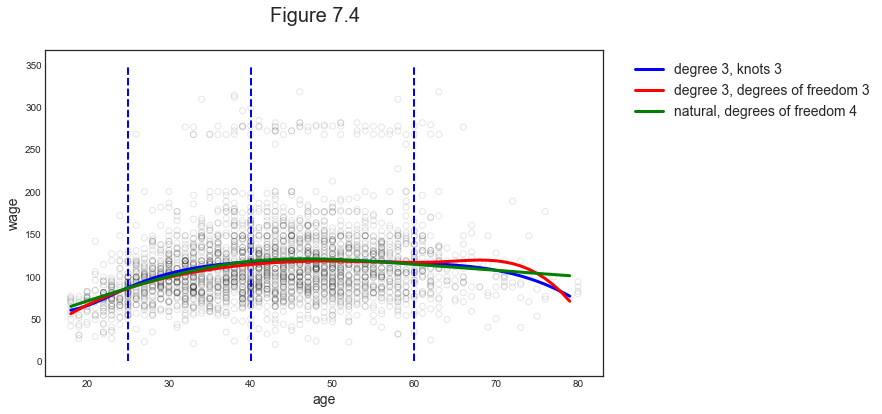

In [84]:

fig, ax = plt.subplots(1,1)
fig.suptitle('Figure 7.4')

# Scatter
ax.scatter(df.age, y, facecolor='None', edgecolor='k', alpha=0.1)
ax.plot(age_grid, pred5, color='b', label='degree 3, knots 3')
ax.plot(age_grid, pred6, color='r', label='degree 3, degrees of freedom 3')
ax.plot(age_grid, pred7, color='g', label='natural, degrees of freedom 4')
[ax.vlines(i , 0, 350, linestyles='dashed', lw=2, colors='b') for i in [25,40,60]]
ax.legend(bbox_to_anchor=(1.5, 1.0))
ax.set_xlabel('age'), ax.set_ylabel('wage');

Here we can see the differences of our splines for the individual ranges of wage and age. 

On the one hand, the pre-defined spline with cubic nods and 3 DOF interprets the regression based on the three knots we set. Here, we decide where to place the nods. 

On the other hand, the program decides itself where to set knots based on the DOF constraint we are giving in uniform quantiles around the data. 

Lastly, we can als decide to obtain a more stable distribution by forcing the graph to be linear when being in its extreme values (larger than largest or smaller than smallest knot). 

### Comparison to Polynomial Regression

Regression splines often give superior results to polynomial regression. This is because unlike polynomials, which must use a high degree to produce flexible fits, splines introduce flexibility by increasing the number of knots but keeping the degree fixed.

We are now fitting a polynomial of degree 15 and a spline with 15 degrees of freedom.

In [88]:
# Polynomial of 15 degrees:

poly_15 = PolynomialFeatures(15).fit_transform(df.age.values.reshape(-1,1))
ols_poly_15 = sm.OLS(y, poly_15).fit()
pred_15_poly = ols_poly_15.predict(PolynomialFeatures(15).fit_transform(age_grid))

# Spline with 15 DOF: 

spline_15 = "bs(x, df = 15, degree = 3, include_intercept = False)"
transformed_x15 = dmatrix(spline_15, {"x":df.age}, return_type = "dataframe")
ols_spline_15 = sm.OLS(y, transformed_x15).fit()
pred_15_spline = ols_spline_15.predict(dmatrix(spline_15, {"x":age_grid}, return_type = "dataframe"))


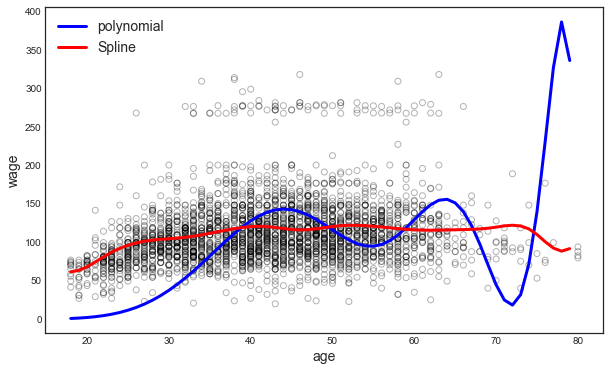

In [92]:
fig, ax = plt.subplots(1,1)

ax.scatter(df.age, df.wage, facecolor = "None", edgecolor = "k", alpha = 0.3)
ax.plot(age_grid, pred_15_poly, color = "b", label = "polynomial")
ax.plot(age_grid, pred_15_spline, color = "r", label = "Spline")
ax.set_xlabel('age'); ax.set_ylabel('wage'); ax.legend();





As we can see, despite the two regressions having the same degrees of freedom, **the polynomial fit is much more volatile**. We can compare them along some dimensions.

In [94]:
# Commpare fits

ols = sm.OLS(df.wage, df.age).fit()
sm.stats.anova_lm(ols, ols_poly_15, ols_spline_15, typ = 1)

/Users/nikolas.anic/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/nikolas.anic/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/nikolas.anic/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2999.0,6.402646e+06,0.0,NaN,NaN,NaN
1,2994.0,9.023503e+06,5.0,-2.620856e+06,-329.264805,1.0
2,2984.0,4.750362e+06,10.0,4.273141e+06,268.422721,0.0


## Local Regression

So far we have looked at so-called "global methods": methods that try to fit a unique function specification over the whole data. The function specification can be complex, as in the case of splines, but can be expressed globally.

Local regression is a different approach for fitting flexible non-linear functions, which involves computing the **fit at a target point $x_0$ using only the nearby training observations**.

#### Details

How do you output a prediction $\hat y_i$ at a new point $x_i$?

1. Take a number of points in X close to $x_i$: $X_c$
2. Assign a weight to each of these points
3. Fit a weighted Least Squares regression of $X_c$ on $y_c$
4. Use the estimated coefficient to predict: $\hat y_i = \hat\beta_0 + \hat\beta_1x_i$

In [95]:
np.random.seed(1)

X = np.sort(np.random.uniform(0,1,100))
e = np.random.uniform(-0.5, 0.5, 100)
y = -4*X**2 + 3*X + e

# True Data generating process without noise

X_grid = np.linspace(0,1,100)
y_grid = -4*X_grid**2 + 3*X_grid


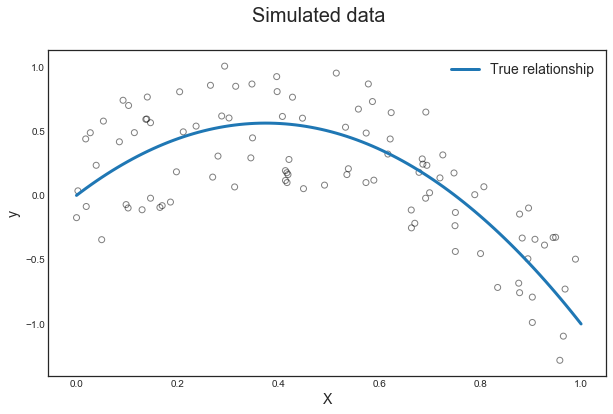

In [97]:
fig, ax = plt.subplots(1,1)
fig.suptitle('Simulated data');

# Plot
ax.scatter(X, y, facecolor='None', edgecolor='k', alpha=0.5);
ax.plot(X_grid, y_grid, label='True relationship');
ax.set_xlabel('X'); ax.set_ylabel('y'); 
ax.legend();

Now we fit a local linear regression:

In [98]:
# Settings
spec = 'll'
bandwidth = 0.1
kernel = 'gaussian'

# locally linear regression

local_reg = KernelReg(y, X.reshape(-1,1),
                     var_type = "c",
                     reg_type = spec, 
                     bw = [bandwidth], 
                     ckertype = kernel)
y_hat = KernelReg.fit(local_reg)


What do the parameters mean?

- var_type: dependent variable type (c i.e. continuous)
- reg_type: local regression specification (ll i.e. locally linear)
- bw : bandwidth length (0.1)
- ckertype: kernel type (gaussian)

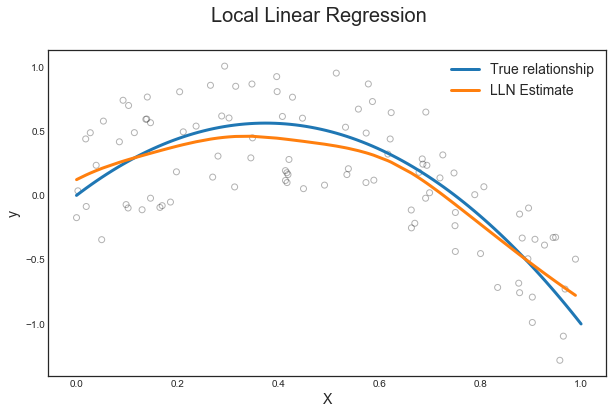

In [103]:

# Figure 7.9
fig, ax = plt.subplots()
fig.suptitle('Local Linear Regression');

# Plot scatter and lines
ax.scatter(X, y, facecolor='None', edgecolor='k', alpha=0.3);
ax.plot(X_grid, y_grid, label='True relationship');
ax.plot(X, y_hat[0], label='LLN Estimate');
ax.set_xlabel('X'); ax.set_ylabel('y');
ax.legend();

Here, the **prediction was generated pointwise**. So for each particular point we $x_i$ we defined a local linear regression in which we estimated a local y for a given interval. 

Let's look at one point: $x_i$ = 0.5 

We proceed as follows: 

1. Select the focal point: 0.5
2. Select the observations close to it: 
    - $x_{\text{close to i}} = \{ x \in X : |x_i - x| < 0.1 \} \ $ and
    - $y_{\text{close to i}} = \{ y \in Y : |x_i - x| &lt; 0.1 \} \$
3. Run a regression of y on x for these particular values

In [104]:
x_i = 0.5 
close_to_i = (x_i - bandwidth < X) & (X < x_i + bandwidth)
X_tilde = X[close_to_i]
y_tilde = y[close_to_i]


local_estimate = KernelReg.fit(local_reg, data_predict=[x_i])
y_i_hat = local_estimate[0]
beta_i_hat = local_estimate[1]
alpha_i_hat = y_i_hat - beta_i_hat*x_i
print('Estimates: alpha=%1.4f, beta=%1.4f' % (alpha_i_hat, beta_i_hat))

Estimates: alpha=0.7006, beta=-0.6141


Now we can use the locally estimated coefficients to predict the value of $\hat y_i(x_i)$ for $x_i = 0.5$:

In [105]:
close_to_i_grid = (x_i-bandwidth < X_grid) & (X_grid < x_i+bandwidth)
X_grid_tilde = X_grid[close_to_i_grid].reshape(-1,1)
y_grid_tilde = alpha_i_hat + beta_i_hat*X_grid_tilde

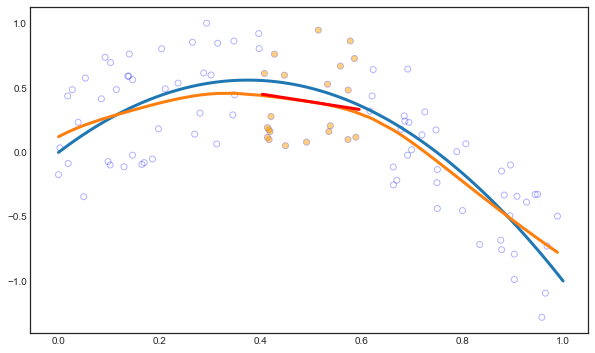

In [106]:
fig, ax = plt.subplots()

ax.scatter(X,y, facecolor = "None", edgecolor = "b", alpha =0.3)
ax.plot(X_grid, y_grid, label='True relationship');
ax.plot(X, y_hat[0], label='LLN Estimate');

# Add local details

ax.scatter(X_tilde, y_tilde, facecolor='orange', edgecolor='None', alpha=0.5);
ax.plot(X_grid_tilde, y_grid_tilde, color = "r", label = "Local OLS")


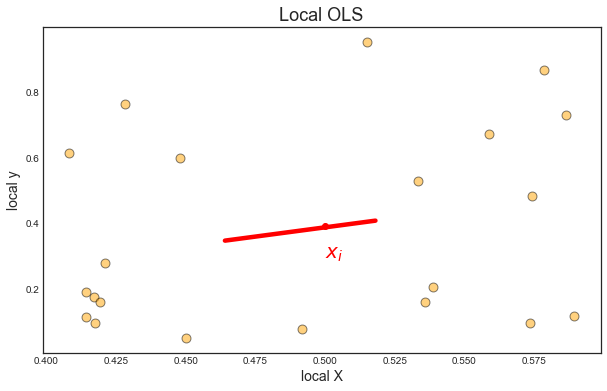

In [107]:
fig, ax = plt.subplots()
ax.set_title('Local OLS');

# Zoom in
sns.regplot(x=X_tilde, y=y_tilde, ax=ax, order=1, 
            ci=None, scatter=False, line_kws={'color':'red'})
ax.scatter(X_tilde,y_tilde, facecolor='orange', edgecolor='k', alpha=0.5, s=80);
ax.scatter(x_i, y_i_hat, facecolor='r', alpha=1);
ax.annotate("$x_i$", (x_i, y_i_hat-0.1), color='r', fontsize=20);
ax.set_xlabel('local X'); ax.set_ylabel('local y');

Note here that the slope is upward. This is because we **forgot to add Gaussian weights to the process**!

In [111]:
w = norm.pdf((X - x_i)/ bandwidth)

model_wls = sm.WLS(y, sm.add_constant(X), weights = w)
results = model_wls.fit()
print('Estimates: alpha=%1.4f, beta=%1.4f' % tuple(results.params))
y_grid = results.params[0] + X_grid*results.params[1]

Estimates: alpha=0.7006, beta=-0.6141


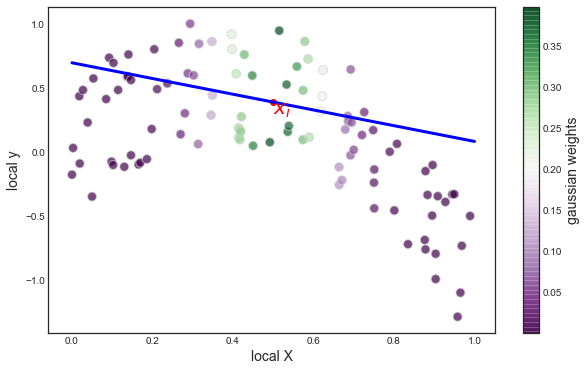

In [115]:
fig, ax = plt.subplots()

points = plt.scatter(X, y, c = w, cmap = "PRGn", edgecolors='lightgrey', alpha=.7, s=80)
plt.colorbar(points, label = "gaussian weights")
ax.plot(X_grid, y_grid, color = "b")
ax.scatter(x_i, y_i_hat, facecolor='r', alpha=1);
ax.annotate("$x_i$", (x_i, y_i_hat-0.1), color='r', fontsize=20);
ax.set_xlabel('local X'); ax.set_ylabel('local y');





Now the slope is indeed negative, as in the locally linear regression.